In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import transforms
plt.rcParams.update({"font.family": "Times New Roman", "font.size": 9})

# r: bb5566, g: 228833, b: 4477aa
# sudo apt-get update && udo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
# sudo apt install msttcorefonts -qq
# rm -rf ~/.cache/matplotlib

In [3]:
high = ["Awe", "Excitement", "Amusement", "Awkwardness", "Fear", "Horror", "Distress", "Triumph", "Sadness", "Surprise"]
two = ["Valence", "Arousal"]
voc_type = ["Voc_Type"]
df = pd.read_csv('../A-VB/labels/data_info.csv', usecols=['File_ID', 'Split', 'Country', *two, *high], low_memory=False)
df2 = pd.read_csv('../A-VB/labels/type_info.csv')
df = pd.merge(df, df2, on=['File_ID', 'Split']).reset_index(drop=True)
print(f"total: {len(df)}, trn: {sum(df['Split'] == 'Train')}, val: {sum(df['Split'] == 'Val')}")
df.head(2)

total: 59201, trn: 19990, val: 19396


,File_ID,Split,Country,Awe,Excitement,Amusement,Awkwardness,Fear,Horror,Distress,Triumph,Sadness,Surprise,Valence,Arousal,Voc_Type
0,[00000],Train,China,0.025647,0.196141,1.000000,0.170493,0.000000,0.044700,0.0,0.164143,0.000000,0.041768,0.746642,0.780055,Laugh
1,[00001],Train,China,0.000000,0.339377,0.572805,0.312748,0.286119,0.292351,1.0,0.000000,0.369405,0.134561,0.225464,0.810526,Grunt


In [4]:
df_trn = df[df['Split'] == 'Train']

In [5]:
Counter(df_trn['Voc_Type']).most_common()

[('Gasp', 7104),
 ('Laugh', 4940),
 ('Cry', 1845),
 ('Scream', 1573),
 ('Groan', 1366),
 ('Other', 1348),
 ('Grunt', 1347),
 ('Pant', 467)]

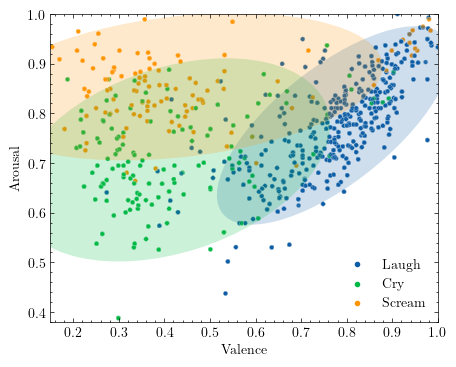

In [6]:
with plt.style.context('science', 'scatter'):
    plt.figure(figsize=(5, 4))
    # ax = plt.subplot(111, aspect='equal')
    plt.xlim(0.15, 1)
    plt.ylim(0.38, 1)
    labels = ['Laugh', 'Cry', 'Scream']
    # colors = ['#bfbf00', '#bf00bf', '#00bfbf', '#ff0000', '#bfbfbf']
    ax = sns.scatterplot(data=df_trn[df_trn['Voc_Type'].isin(labels)], x='Valence', y='Arousal', hue='Voc_Type', s=10, alpha=0.5)
    lgnd = plt.legend(loc='lower right')
    colors = []
    for l in lgnd.legendHandles:
        l._sizes = [9]
        colors.append(l.get_facecolor())
    t = 4.60  # 卡方概率, 自由度2, P值0.1
    for i in range(len(labels)):
        di = df_trn[df_trn['Voc_Type'].isin([labels[i]])]
        x, y = di['Valence'], di['Arousal']
        cov = np.cov(x, y)
        lambda_, v = np.linalg.eig(cov)
        lambda_ = np.sqrt(lambda_)
        ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                      width=lambda_[0] * np.sqrt(t) * 2, height=lambda_[1] * np.sqrt(t) * 2,
                      angle=np.rad2deg(np.arccos(v[0, 0])), facecolor=colors[i], alpha=0.2)
        ax.add_artist(ell)
    # for i in range(len(labels)):
    #     plt.scatter(
    #         df_trn.loc[df_trn['Voc_Type'] == labels[i], 'Valence'],
    #         df_trn.loc[df_trn['Voc_Type'] == labels[i], 'Arousal'],
    #         c=colors[i],
    #         s=5,
    #         alpha=0.3,
    #     )
    # plt.legend(labels, loc="lower right")
    plt.savefig('./tmp/type_two.png', dpi=500)


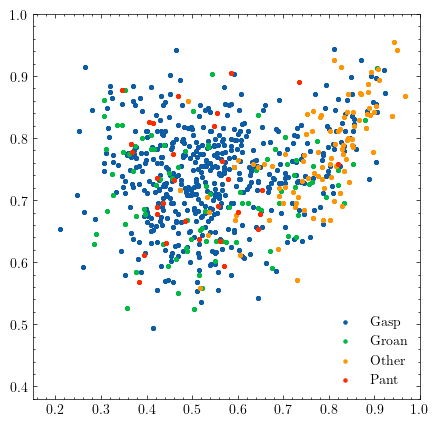

In [7]:
with plt.style.context('science', 'scatter'):
    plt.figure(figsize=(5,5))
    plt.xlim(0.15, 1)
    plt.ylim(0.38, 1)
    # sns.scatterplot(data=df_trn[df_trn['Voc_Type'].isin(['Gasp', 'Groan', 'Other', 'Pant'])], x='Valence', y='Arousal', hue='Voc_Type', alpha=0.1)
    labels = ['Gasp', 'Groan', 'Other', 'Pant']
    for i in range(len(labels)):
        plt.scatter(
            df_trn.loc[df_trn['Voc_Type'] == labels[i], 'Valence'],
            df_trn.loc[df_trn['Voc_Type'] == labels[i], 'Arousal'],
            # c=colors[i],
            s=5,
            # alpha=0.3,
        )
    plt.legend(labels, loc="lower right")

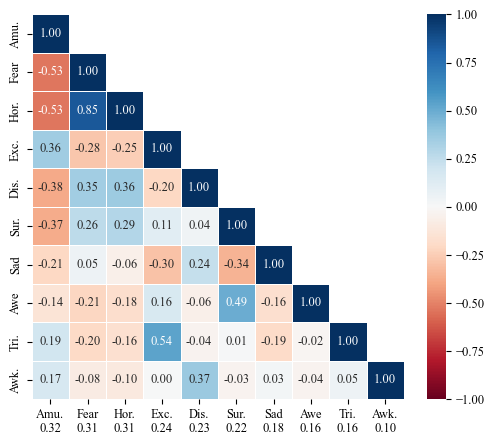

In [28]:
# with plt.style.context('science', 'no-latex'):
plt.figure(figsize=(6, 5))
df_high = df_trn.loc[:, high].rename(columns={"Excitement": "Exc.", "Amusement": "Amu.", "Awkwardness": "Awk.", "Horror": "Hor.", "Distress": "Dis.", "Triumph": "Tri.", "Sadness": "Sad", "Surprise": "Sur."})
corr = df_high.corr()
sum_corr = dict(corr.abs().sum(0) - 1)
sorted_keys = list(dict(sorted(sum_corr.items(), key=lambda item: item[1])).keys())
corr = df_high[sorted_keys[::-1]].corr()
mean_corr = {k: sum_corr[k] / (len(sorted_keys) - 1) for k in sorted_keys[::-1]}
# corr
mask = np.zeros_like(corr, dtype=np.bool_)
for i in range(len(mask)):
    mask[i, i+1:] = 1
ax = sns.heatmap(corr, mask=mask, cmap='RdBu', annot=True, fmt=".2f", square=False, linewidth=.5, vmin=-1.0, vmax=1.0)
ax.set_xticklabels([f"{k}\n{v:.2f}" for k, v in mean_corr.items()])
plt.savefig('./tmp/high_corr.png', dpi=500)